# Learning about Kalman filter

Resource:

`Kalman Filter from Ground Up`; author Alex Becker

+ Python examples

https://www.kalmanfilter.net 

Bought the E-Book and will try to work through as many pages as possible ...


---

I am starting with chapter 3 `The alpha-beta-gamma filter`

---

## Example 1 - weighing the gold

A gold bar is weighed several times. Due to limited measurement accuracy the weight at each time instant will in general be different from all other measurement. The first measurement is denoted $z_1$, the second $z_2$ up to the n'th measurement $z_n$.

The estimated weight at time step $n$ is denoted $\hat x_{n,n}$. It is plausible to compute this estimate as the average of the $n$ available measurements which are availble at this time instant.

$$
\hat x_{n,n} = \frac{1}{n} \sum_{i=1}^{n} z_i
$$

This equation is re-formulated with the aim to get a formula which can be evaluated recursively; not requiring to remember all previous measurements:

$$\begin{split}
\hat x_{n,n} &= \frac{1}{n} \sum_{i=1}^{n} z_i \\
&= \frac{1}{n} \sum_{i=1}^{n-1} z_i + \frac{1}{n} \cdot z_n \\
&= \frac{1}{n} \cdot \frac{n-1}{n-1} \sum_{i=1}^{n-1} z_i + \frac{1}{n} \cdot z_n \\
&= \frac{n-1}{n} \cdot \underbrace{\frac{1}{n-1} \sum_{i=1}^{n-1} z_i}_{\hat x_{n-1,n-1}} + \frac{1}{n} \cdot z_n \\
&= \frac{n-1}{n} \cdot \hat x_{n-1,n-1} + \frac{1}{n} \cdot z_n \\
&= \hat x_{n-1,n-1} + \frac{1}{n} \cdot \left(z_n  - \hat x_{n-1,n-1} \right)
\end{split}
$$


Some other notations are introduced here:

At a future time instant $n+1$ the estimated value is predicted at time $n$ to be $\hat x_{n+1,n}$. Obviously $\hat x_{n,n-1}$ is the predicted value for time instant $n$ when the prediction is made on time instant $n-1$.

Since our system model is about weighing a gold bar the prediction is:

$$
\hat x_{n+1,n} = \hat x_{n,n}
$$

and

$$
\hat x_{n,n-1} = \hat x_{n-1,n-1}
$$

$$
\hat x_{n,n} = \hat x_{n,n-1} + \underbrace{\frac{1}{n}}_{\alpha_n} \cdot \left(z_n  - \hat x_{n,n-1} \right)
$$

The term $\left(z_n  - \hat x_{n,n-1} \right)$ is the meausurement *residual* (deviation of current measurment from predicted value). The scaling factor $\alpha_n$ is in this case 

$$
\alpha_n = \frac{1}{n}
$$

At time step $n=1$ we have:

$$
\hat x_{1,1} = \hat x_{1,0} + \alpha_1 \cdot \left(z_1  - \hat x_{1,0} \right)
$$

Since $\hat x_{1,0}$ cannot be infered from a measurement (there is no measurement for time instant $n=0$) we just use a plausible starting value. Or we can just use the first measurement as a starting value $\hat x_{1,0} := z_1$.



In [17]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

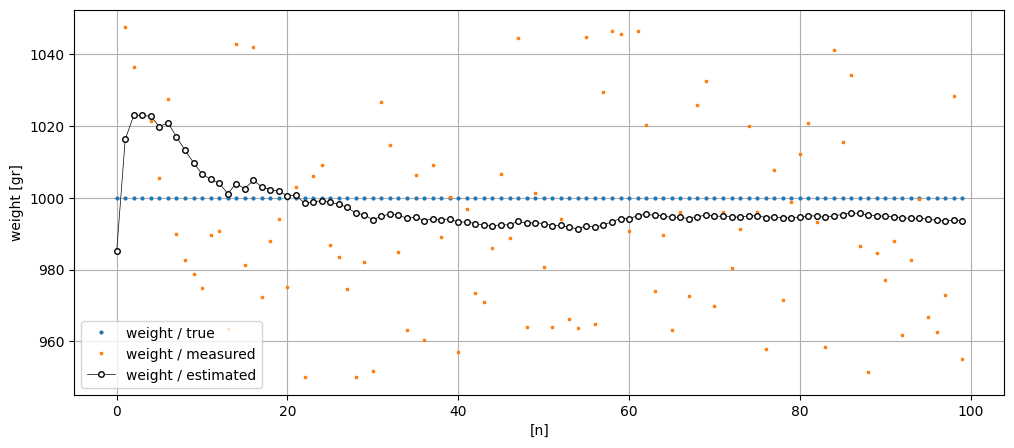

In [18]:
spread = 100
loc = -spread/2
N = 100
x_true = 1000
z_weights = x_true + stats.uniform.rvs(loc, spread, N)

xp = z_weights[0]
x_est = []
for n, z in enumerate(z_weights):
    alpha = 1.0/(n+1)
    xpn = xp + alpha * (z - xp)
    xp = xpn
    x_est.append(xpn)

x_ext = np.array(x_est)

fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12,5))

ax1.plot(np.arange(N), [x_true]*N, linestyle='', marker='o', markersize=2, label='weight / true')
ax1.plot(np.arange(N), z_weights, linestyle='', marker='s', markersize=2, label='weight / measured')
ax1.plot(np.arange(N), x_est, color='k', linewidth=0.5, linestyle='-', marker='o', markersize=4, markerfacecolor='w', label='weight / estimated')
ax1.set_xlabel('[n]')
ax1.set_ylabel('weight [gr]')
ax1.set_title('')
ax1.legend()
ax1.grid(True)

---

## Example 2 – Tracking the constant velocity aircraft

everything in this notebook relates to and is adapted from chapter 3 of 

`Kalman Filter from Ground Up`; author Alex Becker

https://www.kalmanfilter.net 

The examples is about tracking an object which is assumed to have constant velocity. The purpose is twofold:

1) Tracking its position

2) Tracking its velocity

At the beginning of the tracking procedure the initial position and the initial velocity is not exactly known. We just have initial estimates of these properties. The tracking procedure should improve these estimates.

The examples introduces some new notation .



----

## Problem statement

The position of the object is denoted $x$. The velocity $v$ is therefore its derivative with respect to time $t$.

$\dot{x} = v = \frac{d x}{d t}$

For discrete time measurements (eg. a radar takes measurements at time intervals $\Delta t$ apart):

$v = \frac{\Delta x}{\Delta t}$

Since we assume motion with constant velocity we set up the motion equations for time step $t_{n+1} = (n+1) \cdot \Delta t$.

**State Extrapolation Equation / Prediction Equation**

$$\begin{split}
x_{n+1} &= x_n + \Delta t \cdot \dot{x}_n \\
\dot{x}_{n+1} &= \dot{x}_{n}
\end{split}
$$

Since we assumed a model with constant velocity the velocity at the next time step does not change.

In order to introduce some new notation the *prediction equations* are re-written:

$$\begin{split}
\hat{x}_{n, n-1} &= \hat{x}_{n-1, n-1} + \Delta t \cdot \hat{\dot{x}}_{n-1, n-1}  \\
\hat{\dot{x}}_{n, n-1} &= \hat{\dot{x}}_{n-1, n-1}
\end{split}
$$

The caret symbol $\ \hat{ } \ $ denotes *predicted* values. The tuples of time indices $y_{n, n-1}$, $y_{n, n}$, $y_{n-1, n-1}$ shall be interpreted like this:


| symbol | description |
|:---------------|---------------|
|$y_{n, n-1}$   | value $y$ for time step $n$ using information available at time step $n-1$ |
|$y_{n, n}$     | value $y$ for time step $n$ using information available at time step $n$           |
|$y_{n-1, n-1}$ | value $y$ for time step $n-1$ using information available at time step $n-1$             |

With these definitions in place the parts of the prediction equation become:

$\hat{x}_{n, n-1} $ is the predicted postion $x$ at time step $n$ using the predicted position of time step $n-1$ (based on the information available at time step $n-1$) and the predicted velocity of time step $n-1$ ((based on the information available at time step $n-1$).

$\hat{\dot{x}}_{n, n-1}$ is the predicted velocity at time step $n$ using the predicted velocity of time step $n-1$ (based on the information available at time step $n-1$).

An example shall clarify the use of the prediction equations.

At time $n-1$ the *estimated* position shall be $\hat{x}_{n-1, n-1} = 30000 \ [m]$ and the *estimated* velocity $\hat{\dot{x}}_{n-1, n-1} = 40 \ [m/s]$. 

With these estimated values for position and velocity we use the prediction equations to compute predictions for position and velocity for the next time step $n$ based on information we had at time step $n-1$. A time step interval of $\Delta t = 5 \ [s]$ is used.

$$\begin{split}
\hat{x}_{n, n-1} &= 30000 \ [m] + 5 \cdot 40 \ [m] = 30200 \ [m]  \\
\hat{\dot{x}}_{n, n-1} &= 40 \ [m/s]
\end{split}
$$

A new measurement of the target position becomes available at time step $n$. The measured position is $z_n = 30110 \ [m]$. The measurement differs from the predicted position by $z_n - \hat{x}_{n, n-1} = -90 \ [m]$. Several reason may be the cause for this difference:

1) the assumptions of position and velocity in the prediction equation deviate from there true values (most likely)

2) the target position can only be measured with finite accuracy. There will always be some measurement error. A lower measurement error (eg: 5 m) should make us a predict a position closer to the measured value of $z_n$.


With this in mind the estimation procedure would be:

$$
\hat{x}_{n, n} = \hat{x}_{n, n-1} + \alpha \cdot \left(z_n - \hat{x}_{n, n-1} \right)
$$

Factor $\alpha$ is in the range $[0, \ldots, 1]$. The larger the value of $\alpha$ the more reliable the position measurement is.

In a similar way we set up the equation for the estimated velocity:

$$
\hat{\dot{x}}_{n, n} = \hat{\dot{x}}_{n, n-1} + \beta \cdot \frac{\left(z_n - \hat{x}_{n, n-1} \right)}{\Delta t}
$$

**Summary**

The equations for computing the estimated position and velocity are summarized here:

$$\begin{split}
\hat{x}_{n, n} &= \hat{x}_{n, n-1} + \alpha \cdot \left(z_n - \hat{x}_{n, n-1} \right) \\
\hat{\dot{x}}_{n, n} &= \hat{\dot{x}}_{n, n-1} + \beta \cdot \frac{\left(z_n - \hat{x}_{n, n-1} \right)}{\Delta t}
\end{split}
$$

Some literature refers to this equation as the `g-h` filter where factors $g$ and $h$ are just replacements of factors $\alpha$ and $\beta$.

A very readable account on the `g-h`-filter is:

`TRACKING AND KALMAN FILTERING MADE EASY`; author: Eli Brookner; publisher: John Wiley


**Note**

Factors $\alpha$ and $\beta$ are assumed to be **constants** which must be chosen appropriately.


A numerical example of the $\alpha - \beta$-filter is taken from 

`Kalman Filter from Ground Up`

From the same book a diagram of the algorithm is provide in this notebook.

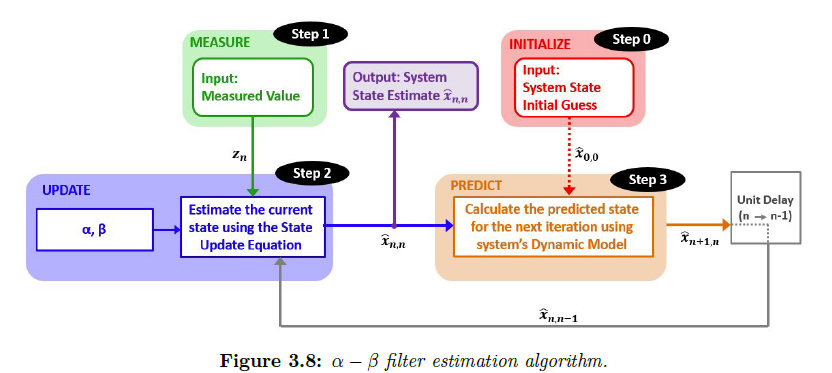



**Numerical Example**

$$\begin{split}
\alpha &= 0.2 \\
\beta &= 0.1 \\
\Delta t &= 5 \ [s]
\end{split}
$$

Initialisation

$$\begin{split}
\hat{x}_{0, 0} &= 30000 \ [m/s] \\
\hat{\dot{x}}_{0, 0} &= 40 \ [m/s]
\end{split}
$$

Measurements (again from `Kalman Filter from Ground Up`, https://www.kalmanfilter.net)

$$\begin{split}
z_1 &= 30171 \ [m] \\
z_2 &= 30353 \ [m] \\
z_3 &= 30756 \ [m] \\
z_4 &= 30799 \ [m] \\
z_5 &= 31018 \ [m] \\
z_6 &= 31278 \ [m] \\
z_7 &= 31276 \ [m] \\
z_8 &= 31379 \ [m] \\
z_9 &= 31748 \ [m] \\
z_{10} &= 32175 \ [m]
\end{split}
$$

The next section is mainly a copy of the numerical example in `Kalman Filter from Ground Up` (along with some annotations).

---

**Time step n=1; t = 0**

Prediction for n=1

*Deviating* from the numerical example in the book it seems plausible to use the *measured* position $z_1$ to predict $x_{1,0}$. In the book the prediction update equation is used; but no justification is provided. The best possible knowledge about the position we have at $n=0$ is the measurement $z_1$. 

As there is no such measurement for the velocity the predicted velocity $\dot{x}_{1,0} $ shall use the initial assumption about the vecocity.

$$\begin{split}
x_{1,0} &= z_1 = 30171 \ m\\
\dot{x}_{1,0} &= \dot{x}_{0,0} = 40 \ m/s
\end{split}
$$

Estimation for n=1

$$\begin{split}
x_{1,1} &= x_{1,0} = 30171 \ m \\
\dot{x}_{1,1} &= \dot{x}_{1,0} = 40 \ m/s
\end{split}
$$

**Time step n=2; t = 5 s**

Prediction for n=2

$$\begin{split}
\hat{x}_{2, 1} &= \hat{x}_{1, 1} + \Delta t \cdot \hat{\dot{x}}_{1, 1}  = 30171 \ m + 5 \cdot 40 \ m = 30371 \ m \\
\hat{\dot{x}}_{2, 1} &= \hat{\dot{x}}_{1, 1} = 40 \ m/s
\end{split}
$$

Estimation for n=2

Taking into account measurement $z_2=30353 \ m$:

$$\begin{split}
\hat{x}_{2, 2} &= \hat{x}_{2, 1} + \alpha \cdot \left(z_2 - \hat{x}_{2, 1} \right) = 30371 \ m + 0.2 \cdot  \left(30353 - 30371 \right) \ m = 30371 \ m - 0.2 \cdot  18 \ m  = 30367.4 \ m\\
\hat{\dot{x}}_{2, 2} &= \hat{\dot{x}}_{2, 1} + \beta \cdot \frac{\left(z_2 - \hat{x}_{2, 1} \right)}{\Delta t} = 40 \ m/s + 0.1 \cdot \frac{30353 - 30371}{5} = 40 \ m/s - 0.1 \cdot \frac{18}{5} = 40 \ m/s  - 0.36 \ m/s  = 39.64 \ m/s
\end{split}
$$

**Time step n=3; t = 10 s**

Prediction for n=3

$$\begin{split}
\hat{x}_{3, 2} &= \hat{x}_{2, 2} + \Delta t \cdot \hat{\dot{x}}_{2, 2}  = 30367.4 \ m + 5 \cdot 39.64 \ m = 30565.6 \ m \\
\hat{\dot{x}}_{3, 2} &= \hat{\dot{x}}_{2, 2} = 39.64 \ m/s
\end{split}
$$

Estimation for n=3

Taking into account measurement $z_3=30756 \ m$:

$$\begin{split}
\hat{x}_{3, 3} &= \hat{x}_{3, 2} + \alpha \cdot \left(z_3 - \hat{x}_{3, 2} \right) = 30565.6 \ m + 0.2 \cdot  \left(30756 - 30565.6 \right) \ m = 30565.6 \ m + 0.2 \cdot  190.4 \ m  = 30603.68 \ m\\
\hat{\dot{x}}_{3, 3} &= \hat{\dot{x}}_{3, 2} + \beta \cdot \frac{\left(z_3 - \hat{x}_{3, 2} \right)}{\Delta t} = 39.64 \ m/s + 0.1 \cdot \frac{30756 - 30565.6}{5} = 39.64 \ m/s + 0.1 \cdot \frac{190.4 }{5} = 39.64 \ m/s + 6.332 \ m/s = 43.448 \ m/s
\end{split}
$$

k: 0 : x_pred: 30171.000 v_pred: 40.000 x_est: 30171.000 v_est: 40.000
k: 1 : x_pred: 30371.000 v_pred: 40.000 x_est: 30367.400 v_est: 39.640
k: 2 : x_pred: 30565.600 v_pred: 39.640 x_est: 30603.680 v_est: 43.448
k: 3 : x_pred: 30820.920 v_pred: 43.448 x_est: 30816.536 v_est: 43.010
k: 4 : x_pred: 31031.584 v_pred: 43.010 x_est: 31028.867 v_est: 42.738
k: 5 : x_pred: 31242.557 v_pred: 42.738 x_est: 31249.645 v_est: 43.447
k: 6 : x_pred: 31466.879 v_pred: 43.447 x_est: 31428.703 v_est: 39.629
k: 7 : x_pred: 31626.849 v_pred: 39.629 x_est: 31577.280 v_est: 34.672
k: 8 : x_pred: 31750.641 v_pred: 34.672 x_est: 31750.112 v_est: 34.619
k: 9 : x_pred: 31923.209 v_pred: 34.619 x_est: 31973.568 v_est: 39.655


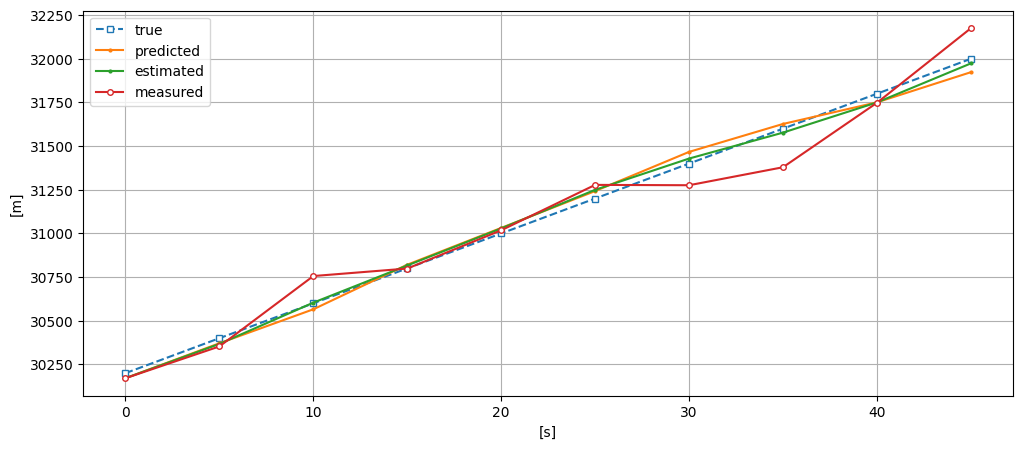

In [19]:
x_estimate_initial = 30200.0
v_estimate_initial = 40
alpha = 0.2 
beta = 0.1
dt = 5.0

z_measurements = np.array([30171, 30353, 30756, 30799, 31018, 31278, 31276, 31379, 31748, 32175])

x_predictions = []
v_predictions = []
x_estimates = []
v_estimates = []

for k, z_measured in enumerate(z_measurements): 
    if k==0:
        # init
        x_predicted=z_measured
        v_predicted=v_estimate_initial
        x_estimated = x_predicted
        v_estimated = v_predicted
    else:
        # prediction update
        x_predicted = x_estimated + dt * v_estimated
        v_predicted = v_estimated
        residual = z_measured - x_predicted
        # new estimates
        x_estimated = x_predicted + alpha*residual
        v_estimated = v_predicted + beta * residual /dt
    
    x_estimates.append(x_estimated)
    v_estimates.append(v_estimated)
    x_predictions.append(x_predicted)
    v_predictions.append(v_predicted)

    # printing predicted / estimated position & velocity
    print(f"k: {k} : x_pred: {x_predicted:.3f} v_pred: {v_predicted:.3f} x_est: {x_estimated:.3f} v_est: {v_estimated:.3f}")

# the data of the true positions are fictitious data (not available in the book !)
time_steps = np.arange(len(z_measurements)) * dt
x_true = x_estimate_initial + time_steps * v_estimate_initial

# do graphics
fig2, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(12,5))

ax2.plot(time_steps, x_true, linestyle='--', marker='s', markersize=4, markerfacecolor='w', label='true')
ax2.plot(time_steps, x_predictions, linestyle='-', marker='o', markersize=2, label='predicted')
ax2.plot(time_steps, x_estimates, linestyle='-', marker='o', markersize=2, label='estimated')
ax2.plot(time_steps, z_measurements, linestyle='-', marker='o', markersize=4, markerfacecolor='w', label='measured')

ax2.set_xlabel('[s]')
ax2.set_ylabel('[m]')
ax2.set_title('')
ax2.legend()
ax2.grid(True)   

**Summary**

Compared to measurement the smoothing effect for the predicted and estimated positions is noticable.

---

## Example 3 – Tracking aircraft with acceleration

everything in this notebook relates to and is adapted from chapter 3 of 

`Kalman Filter from Ground Up`; author Alex Becker

https://www.kalmanfilter.net 

**Model**

From $t=0$ to $t=t_1$ the aircraft moves with constant velocity $v_c$.

Starting from time $t=t_1$ the aircraft is accelerated by a constant accelaration $a_c$.

The velocity starts to increase for $t \ge t_1$.

Let $x_0$ denote the initial position of the aircraft at $t=0$.

For the time interval $0 \le t \le t_1$ the position of the aircraft is computed:

$$
x(t) = x_0 + v_c \cdot t
$$

At time $t=t_1$ the aircraft is at position $x(t_1)$:

$$
x(t_1) = x_0 + v_c \cdot t_1
$$

For the time interval $t \ge t_1$ the aircraft's position is:

$$
x(t) = x_0 + v_c \cdot t + \frac{1}{2} \cdot a_c \cdot \left(t - t_1 \right)^2
$$

For numerical evaluation we transform these equations into time discrete equations. The time increment is denoted $\Delta t$.

For time $t=0$ to $t_1 = (K-1) \cdot \Delta t$ the aircraft moves with constant velocity.

$$
x_k = x_0 + v_c \cdot k \cdot \Delta t  ; with \ 0 \le k \lt K
$$

Then the constant accelaration kicks in:

$$
x_k = x_0 + v_c \cdot k \cdot \Delta t + \frac{1}{2} \cdot a_c \cdot \left((k - (K-1)) \cdot \Delta t\right)^2  ; \ with \ k \ge K
$$

We design a data set with these parameters:

$$\begin{split}
x_0 &= 20.0 \\
\Delta t &= 5.0 \ s\\
K &= 20 \\
0 &\le k \lt 100 \\
v_c &= 50 \ m/s \\
a_c &= 8.0 \ m/s^2
\end{split}
$$

In [20]:
x0 = 20.0
dt = 5.0
K = 20
M = 100
vc = 50.0
ac = 8.0

x = x0 + vc * np.arange(M) * dt
x2 = 0.5 * ((np.arange(K, M) - (K-1)) * dt)**2

# array of positions
x[K:] = x[K:] + x2

tvec = np.arange(M) * dt

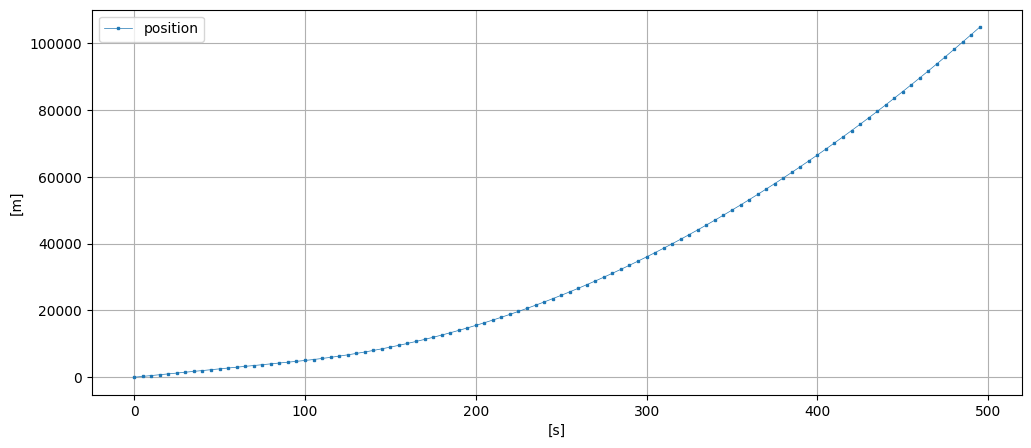

In [21]:
fig3, ax3 = plt.subplots(nrows=1, ncols=1, figsize=(12,5))

ax3.plot(tvec, x, linewidth=0.5, linestyle='-', marker='s', markersize=2, label='position')
ax3.set_xlabel('[s]')
ax3.set_ylabel('[m]')
ax3.set_title('')
ax3.legend()
ax3.grid(True)   

In [22]:
from alpha_beta_filter import alpha_beta_filter


In [23]:
alpha = 0.2
beta = 0.1

x_init = x[0]
v_init = 50

# alpha-beta filtering
x_pred, v_pred, x_est, v_est = alpha_beta_filter(x, x_init, v_init, dt, alpha, beta)

x_error = x - x_est

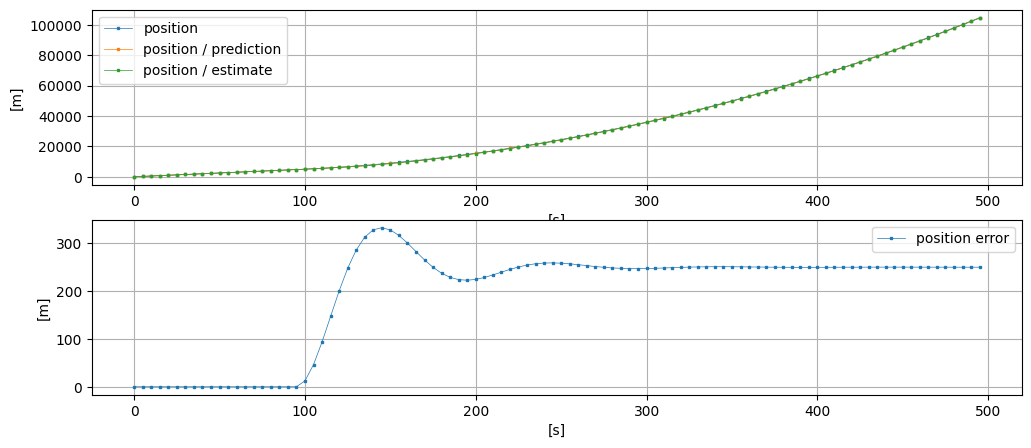

In [24]:
fig4, ax4 = plt.subplots(nrows=2, ncols=1, figsize=(12,5))

ax4[0].plot(tvec, x, linewidth=0.5, linestyle='-', marker='s', markersize=2, label='position')
ax4[0].plot(tvec, x_pred, linewidth=0.5, linestyle='-', marker='s', markersize=2, label='position / prediction' )
ax4[0].plot(tvec, x_est, linewidth=0.5, linestyle='-', marker='s', markersize=2, label='position / estimate' )
ax4[0].set_xlabel('[s]')
ax4[0].set_ylabel('[m]')
ax4[0].set_title('')
ax4[0].legend()
ax4[0].grid(True)   

ax4[1].plot(tvec, x_error, linewidth=0.5, linestyle='-', marker='s', markersize=2, label='position error')
ax4[1].set_xlabel('[s]')
ax4[1].set_ylabel('[m]')
ax4[1].set_title('')
ax4[1].legend()
ax4[1].grid(True)  

**Summary & Observations**

While the velocity remains constant the tracking performance of the $\alpha-\beta$-filter is good. When the constant acceleration sets in the estimates start to lag behind the true positions.

After some time the tracking error is *fairly constant*.

The estimated position and the true position differ by a fixed offset with a steady state error of about 250 m.

**Reason**

The model for computing predicting / estimating position and velocity lack the capability to predict / estimate the acceleration.

---

## Example 4 $\alpha-\beta-\gamma$-filter

A possible enhancment of the $\alpha-\beta$-filter is presented in https://www.kalmanfilter.net .

The prediction and estimation equation now consider the acceleration as well.

As there is not much additional information there is no numerical example in this notebook.

---
